In [1]:
import unicodedata
import string
import re
import random
import time
import math
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
USE_CUDA = False

# Prepare data

In [2]:
SOS_token = 0
EOS_token = 1

CSV_PATH = 'human-machine.csv'

class CharDict:
    def __init__(self):
        self.char2index = {}
        self.char2count = {}
        self.index2char = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_chars = 2

    def addSentence(self, sentence):
        for c in sentence:
            self.addChar(c)

    def addChar(self, char):
        if char not in self.char2index:
            self.char2index[char] = self.n_chars
            self.char2count[char] = 1
            self.index2char[self.n_chars] = char
            self.n_chars += 1
        else:
            self.char2count[char] += 1

In [3]:
def prepare_data():
    df = pd.read_csv(CSV_PATH)
    human = df["human"].values
    machine = df["machine"].values
    pairs = []
    for i in range(len(human)):
        pairs.append([human[i],machine[i]])
        
    input_lang = CharDict()
    output_lang = CharDict()
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data()

In [4]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.char2index[char] for char in sentence]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Building the models

## The Encoder

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## The Decoder

In [6]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            energy = hidden.dot(encoder_output)
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            energy = hidden.dot(energy)
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            energy = self.other.dot(energy)
            return energy

In [7]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

In [8]:
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()


    for di in range(target_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        loss += criterion(decoder_output, target_variable[di])

        # Get most likely word index (highest value) from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]

        decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
        if USE_CUDA: decoder_input = decoder_input.cuda()

        # Stop at end of sentence (not necessary when using known targets)
        if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.data[0] / target_length

In [9]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

In [10]:
attn_model = 'general'
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_chars, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_chars, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

In [11]:
n_epochs = 2600
plot_every = 100
print_every = 200

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

In [12]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

/home/anchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/anchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


1m 13s (- 14m 41s) (200 7%) 1.6692
2m 25s (- 13m 22s) (400 15%) 1.1330
3m 40s (- 12m 16s) (600 23%) 0.5032
4m 59s (- 11m 14s) (800 30%) 0.3321
6m 19s (- 10m 7s) (1000 38%) 0.2221
7m 41s (- 8m 58s) (1200 46%) 0.2167
9m 5s (- 7m 47s) (1400 53%) 0.1544
10m 28s (- 6m 32s) (1600 61%) 0.1804
11m 53s (- 5m 16s) (1800 69%) 0.1411
13m 17s (- 3m 59s) (2000 76%) 0.1186
14m 42s (- 2m 40s) (2200 84%) 0.1103
16m 8s (- 1m 20s) (2400 92%) 0.0971
17m 33s (- 0m 0s) (2600 100%) 0.0590


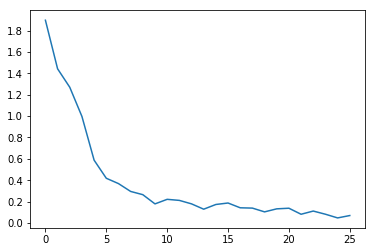

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

In [14]:
def evaluate(sentence, max_length=11):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder.eval()
    decoder.eval()
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2char[ni])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

In [15]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words = evaluate(pair[0])
    output_sentence = ''.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [16]:
evaluate_randomly()

> 17 apr 1980
= 1980-04-17
< 1980-04-17<EOS>



/home/anchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/anchen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
